# Modelización

In [1]:
# Tratamiento de la base de datos
import pandas as pd
import numpy as np

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rf = RandomForestClassifier(random_state = 45)
xgb = XGBClassifier(random_state = 45, colsample_bytree = 0.6, gamma = 5, use_label_encoder = False)

In [3]:
rf_param_grid = {'n_estimators': [50, 100, 200],
                 'min_samples_leaf': [0.01, 0.03, 0.05, 0.1],
                 'max_depth': [3, 5, 7, 9, 11]}

xgb_param_grid = {"learning_rate": [0.01, 0.1],        
                  "reg_lambda": [0.001, 0.1, 1],     
                  "reg_alpha": [0.001, 0.1, 1],      
                  "n_estimators": [100, 200, 300]}


In [4]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [5]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend()
    plt.show()

In [16]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    # ROC CURVE
    y_scores = model.best_estimator_.predict_proba(X_train)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr)
    
    # Predict with threshold of roc curve
    y_pred = (y_scores >= optimal_threshold).astype(int)
    
    # Confusion Matrix
    cf = confusion_matrix(y_train, y_pred)
    make_confusion_matrix(cf, figsize=(8,6), cbar=False, categories = [-1, 1], title = 'Confusion Matrix for training')
    
    # Evaluation
    y_scoresVal = model.best_estimator_.predict_proba(X_test)[:, 1]
    y_predVal = (y_scoresVal >= optimal_threshold).astype(int)
    cfVal = confusion_matrix(y_test, y_predVal)
    make_confusion_matrix(cfVal, figsize=(8,6), cbar=False, categories = [-1, 1], title = 'Confusion Matrix for test')

In [8]:
le = LabelEncoder()

#### Datos 1

In [9]:
df1 = pd.read_csv('datos/datos1.csv')
df1['tendencia'] = df1['tendencia'].astype("category")

X1 = df1.drop(['date', 'tendencia'], axis = 1)
y1 = le.fit_transform(df1['tendencia'])

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

#### Datos 2

In [10]:
df2 = pd.read_csv('datos/datos2.csv')
df2['tendencia'] = df2['tendencia'].astype("category")

X2 = df2.drop(['date', 'tendencia'], axis = 1)
y2 = le.fit_transform(df2['tendencia'])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

#### Datos 3

In [11]:
df3 = pd.read_csv('datos/datos3.csv')
df3['tendencia'] = df3['tendencia'].astype("category")

X3 = df3.drop(['date', 'tendencia'], axis = 1)
y3 = le.fit_transform(df3['tendencia'])

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

#### Datos 4

In [12]:
df4 = pd.read_csv('datos/datos4.csv')
df4['tendencia'] = df4['tendencia'].astype("category")

X4 = df4.drop(['date', 'tendencia'], axis = 1)
y4 = le.fit_transform(df4['tendencia'])

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

# Modelización 1

## RandomForest

In [13]:
# estudiar umbral para determinar la clase
# función de roc_curve alimenar con predict_proba

rf1 = GridSearchCV(
    estimator = rf,
    param_grid = rf_param_grid,
    scoring= 'accuracy', 
    n_jobs = 3, 
    cv = 5, 
    refit = True, 
    return_train_score=True,
    verbose = True)

rf1.fit(X1_train, y1_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   21.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  2.9min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45), n_jobs=3,
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [0.01, 0.03, 0.05, 0.1],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [14]:
results_df1 = pd.concat([pd.DataFrame(rf1.cv_results_["params"]),
                         pd.DataFrame(rf1.cv_results_['mean_train_score'], columns = ["accuracy_train"]),
                         pd.DataFrame(rf1.cv_results_['mean_test_score'], columns = ['accuracy_test'])], 
                         axis=1)

display(results_df1.sort_values(by = 'accuracy_test', ascending=False).head(10))

,max_depth,min_samples_leaf,n_estimators,accuracy_train,accuracy_test
25,7,0.01,100,0.551029,0.537168
24,7,0.01,50,0.550338,0.536784
38,9,0.01,200,0.555281,0.535824
26,7,0.01,200,0.551077,0.535786
37,9,0.01,100,0.554542,0.535479
49,11,0.01,100,0.557460,0.534979
50,11,0.01,200,0.557950,0.534749
48,11,0.01,50,0.558190,0.534403
14,5,0.01,200,0.545298,0.533635
36,9,0.01,50,0.555781,0.532752


Threshold value is: 0.49076187626924184


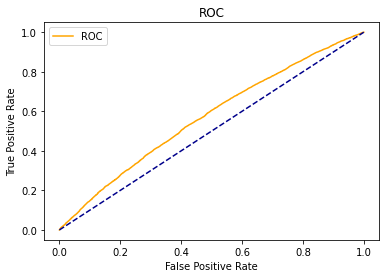

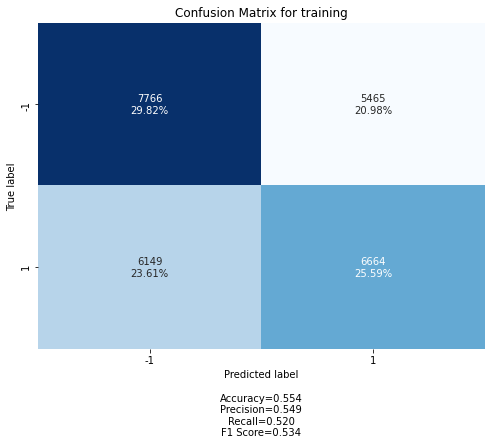

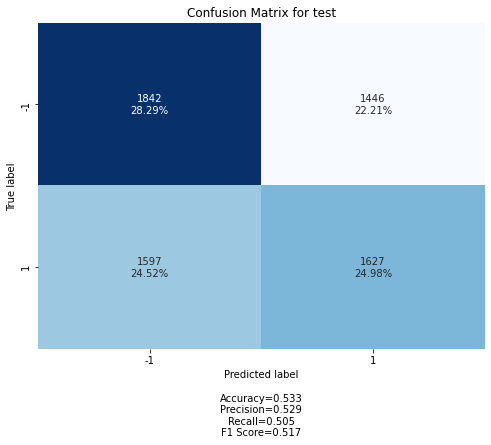

In [17]:
evaluate_model(rf1, X1_train, y1_train, X1_test, y1_test)

## XGBoost

In [18]:
xgb1 = GridSearchCV(estimator = xgb, 
                    param_grid = xgb_param_grid,
                    scoring = 'accuracy',
                    cv = 5, 
                    verbose = 1,
                    n_jobs = 3, 
                    refit = True, 
                    return_train_score=True)

xgb1.fit(X1_train, y1_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   23.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed:  5.1min finished


[21:07:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=5, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=45,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_l

In [19]:
results_df2 = pd.concat([pd.DataFrame(xgb1.cv_results_["params"]),
                         pd.DataFrame(xgb1.cv_results_['mean_train_score'], columns = ["accuracy_train"]),
                         pd.DataFrame(xgb1.cv_results_['mean_test_score'], columns = ['accuracy_test'])], 
                         axis=1)

display(results_df2.sort_values(by = 'accuracy_test', ascending=False).head(10))

,learning_rate,n_estimators,reg_alpha,reg_lambda,accuracy_train,accuracy_test
32,0.1,100,0.100,1.000,0.569843,0.538819
41,0.1,200,0.100,1.000,0.569843,0.538819
50,0.1,300,0.100,1.000,0.569843,0.538819
44,0.1,200,1.000,1.000,0.564036,0.538666
35,0.1,100,1.000,1.000,0.564036,0.538666
53,0.1,300,1.000,1.000,0.564036,0.538666
29,0.1,100,0.001,1.000,0.570995,0.538166
47,0.1,300,0.001,1.000,0.570995,0.538166
38,0.1,200,0.001,1.000,0.570995,0.538166
42,0.1,200,1.000,0.001,0.571542,0.538128


Threshold value is: 0.4936249


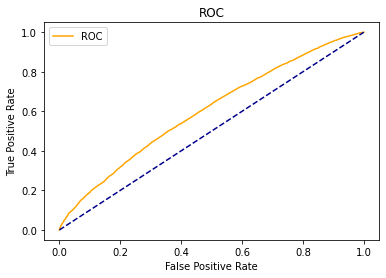

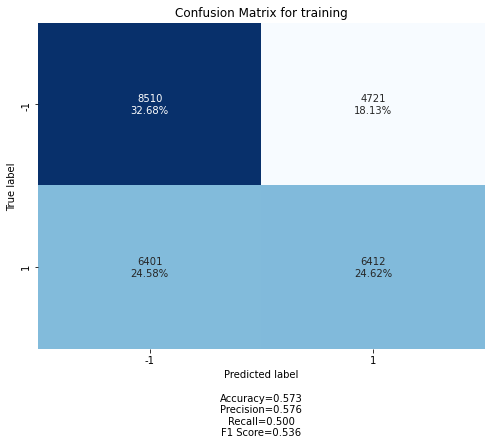

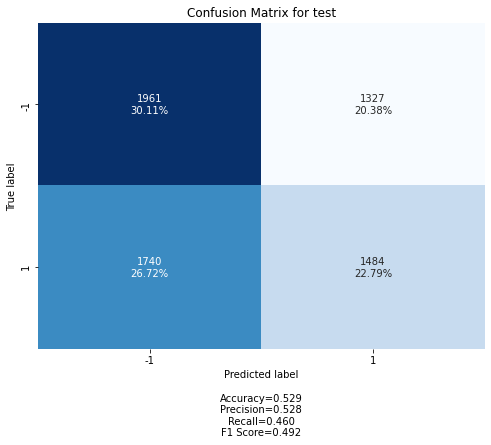

In [20]:
evaluate_model(xgb1, X1_train, y1_train, X1_test, y1_test)

In [21]:
y_scores2 = xgb1.best_estimator_.predict_proba(X1_train)[:, 1]

# Modelización 2

## RandomForest

In [22]:
rf2 = GridSearchCV(
    estimator = rf,
    param_grid = rf_param_grid,
    scoring= 'accuracy', 
    n_jobs = 3, 
    cv = 5, 
    refit = True, 
    return_train_score=True,
    verbose = True)

rf2.fit(X2_train, y2_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   55.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  5.1min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  8.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45), n_jobs=3,
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [0.01, 0.03, 0.05, 0.1],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [23]:
results_df3 = pd.concat([pd.DataFrame(rf2.cv_results_["params"]),
                         pd.DataFrame(rf2.cv_results_['mean_train_score'], columns = ["accuracy_train"]),
                         pd.DataFrame(rf2.cv_results_['mean_test_score'], columns = ['accuracy_test'])], 
                         axis=1)

display(results_df3.sort_values(by = 'accuracy_test', ascending=False).head(10))

,max_depth,min_samples_leaf,n_estimators,accuracy_train,accuracy_test
49,11,0.01,100,0.625346,0.570683
50,11,0.01,200,0.624894,0.570452
48,11,0.01,50,0.622293,0.570183
37,9,0.01,100,0.616947,0.566805
38,9,0.01,200,0.616640,0.566382
36,9,0.01,50,0.613549,0.565422
26,7,0.01,200,0.600668,0.559971
25,7,0.01,100,0.599727,0.558588
24,7,0.01,50,0.597961,0.557437
13,5,0.01,100,0.578688,0.552522


Threshold value is: 0.4942453388886126


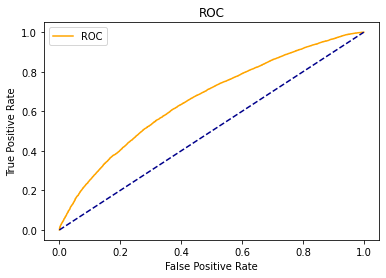

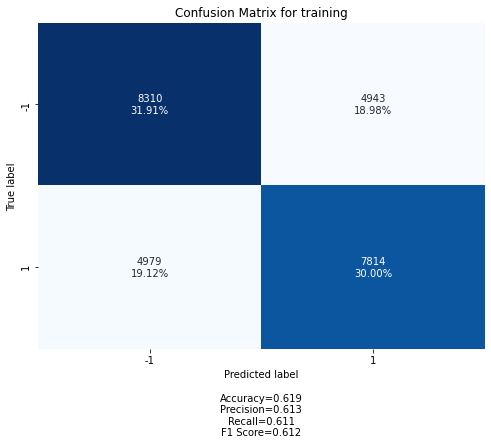

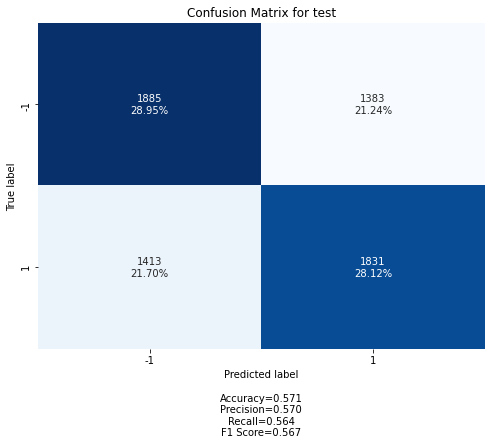

In [24]:
evaluate_model(rf2, X2_train, y2_train, X2_test, y2_test)

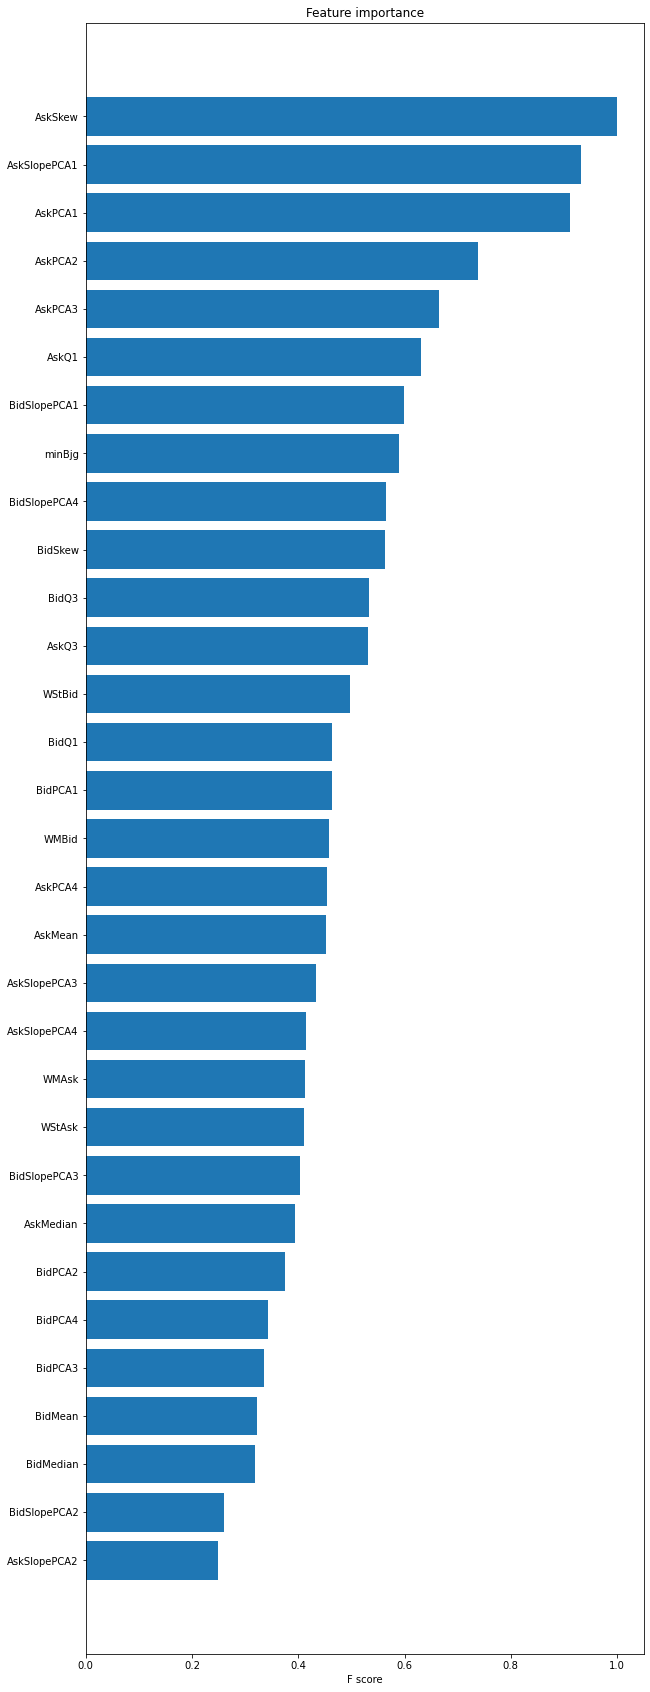

In [25]:
ftImp = rf2.best_estimator_.feature_importances_

# Nombres de las características
features = X2_train.columns

# Normalización importancias
ftImp = ftImp / np.max(ftImp, axis=0)

# Df para ordenar por importancia
featureImportance = pd.DataFrame({'ftImp': ftImp,'features': features })
featureImportance =featureImportance.sort_values(by=['ftImp'])
y_pos = np.arange(len(featureImportance['features']))

# Gráfico de barras
plt.figure(figsize=(10, 30))
plt.barh(y_pos, featureImportance['ftImp'], align='center')
plt.yticks(y_pos, featureImportance['features'])
# plt.axvline(0.1, 0, 1, c='r')
plt.xlabel('F score')
plt.title('Feature importance')
plt.show()

## XGBoost

In [26]:
xgb2 = GridSearchCV(estimator = xgb, 
                    param_grid = xgb_param_grid,
                    scoring = 'accuracy',
                    cv = 5, 
                    verbose = 1,
                    n_jobs = 3, 
                    refit = True, 
                    return_train_score=True)

xgb2.fit(X2_train, y2_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 20.3min
[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed: 31.4min finished


[21:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=5, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=45,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_l

In [27]:
results_df4 = pd.concat([pd.DataFrame(xgb2.cv_results_["params"]),
                         pd.DataFrame(xgb2.cv_results_['mean_train_score'], columns = ["accuracy_train"]),
                         pd.DataFrame(xgb2.cv_results_['mean_test_score'], columns = ['accuracy_test'])], 
                         axis=1)

display(results_df4.sort_values(by = 'accuracy_test', ascending=False).head(10))

,learning_rate,n_estimators,reg_alpha,reg_lambda,accuracy_train,accuracy_test
52,0.1,300,1.000,0.100,0.853164,0.648775
48,0.1,300,0.100,0.001,0.859000,0.644513
51,0.1,300,1.000,0.001,0.849910,0.644436
45,0.1,300,0.001,0.001,0.854268,0.644053
49,0.1,300,0.100,0.100,0.856802,0.643707
53,0.1,300,1.000,1.000,0.835963,0.643055
46,0.1,300,0.001,0.100,0.853250,0.642171
47,0.1,300,0.001,1.000,0.837960,0.640521
50,0.1,300,0.100,1.000,0.835656,0.638869
42,0.1,200,1.000,0.001,0.826931,0.637103


Threshold value is: 0.49911916


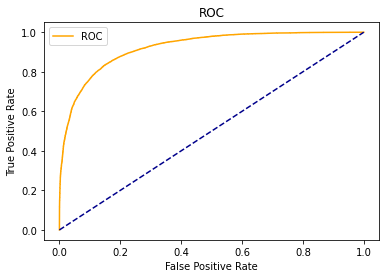

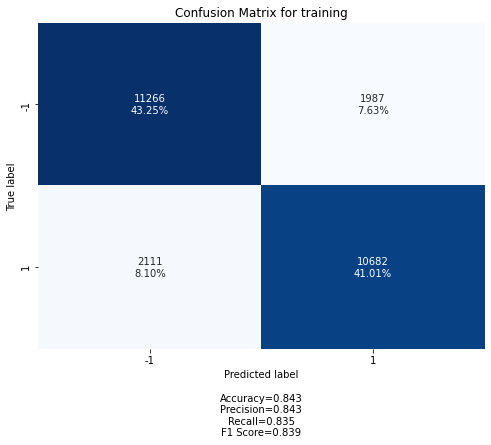

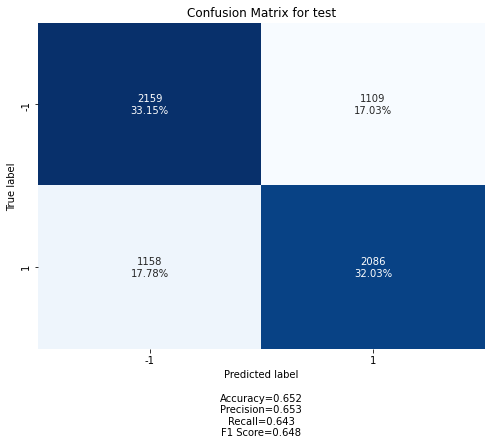

In [28]:
evaluate_model(xgb2, X2_train, y2_train, X2_test, y2_test)

# Modelización 3

## RandomForest

In [29]:
rf3 = GridSearchCV(
    estimator = rf,
    param_grid = rf_param_grid,
    scoring= 'accuracy', 
    n_jobs = 3, 
    cv = 5, 
    refit = True, 
    return_train_score=True,
    verbose = True)

rf3.fit(X3_train, y3_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 12.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45), n_jobs=3,
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [0.01, 0.03, 0.05, 0.1],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [30]:
results_df5 = pd.concat([pd.DataFrame(rf3.cv_results_["params"]),
                         pd.DataFrame(rf3.cv_results_['mean_train_score'], columns = ["accuracy_train"]),
                         pd.DataFrame(rf3.cv_results_['mean_test_score'], columns = ['accuracy_test'])], 
                         axis=1)

display(results_df5.sort_values(by = 'accuracy_test', ascending=False).head(10))

,max_depth,min_samples_leaf,n_estimators,accuracy_train,accuracy_test
50,11,0.01,200,0.623541,0.563854
49,11,0.01,100,0.623714,0.563047
48,11,0.01,50,0.619039,0.562510
37,9,0.01,100,0.617023,0.559899
36,9,0.01,50,0.612454,0.559361
38,9,0.01,200,0.614892,0.558977
25,7,0.01,100,0.600906,0.556482
24,7,0.01,50,0.597748,0.554677
26,7,0.01,200,0.599111,0.553487
12,5,0.01,50,0.576678,0.546230


Threshold value is: 0.49779490027832063


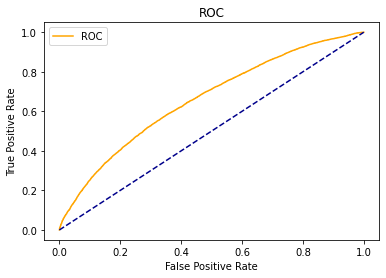

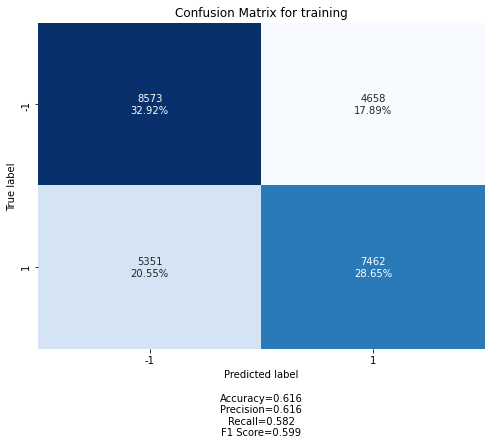

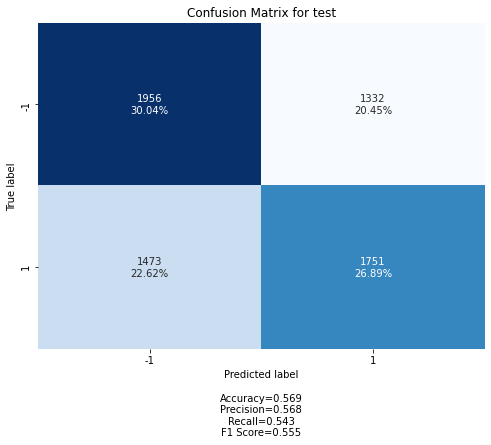

In [31]:
evaluate_model(rf3, X3_train, y3_train, X3_test, y3_test)

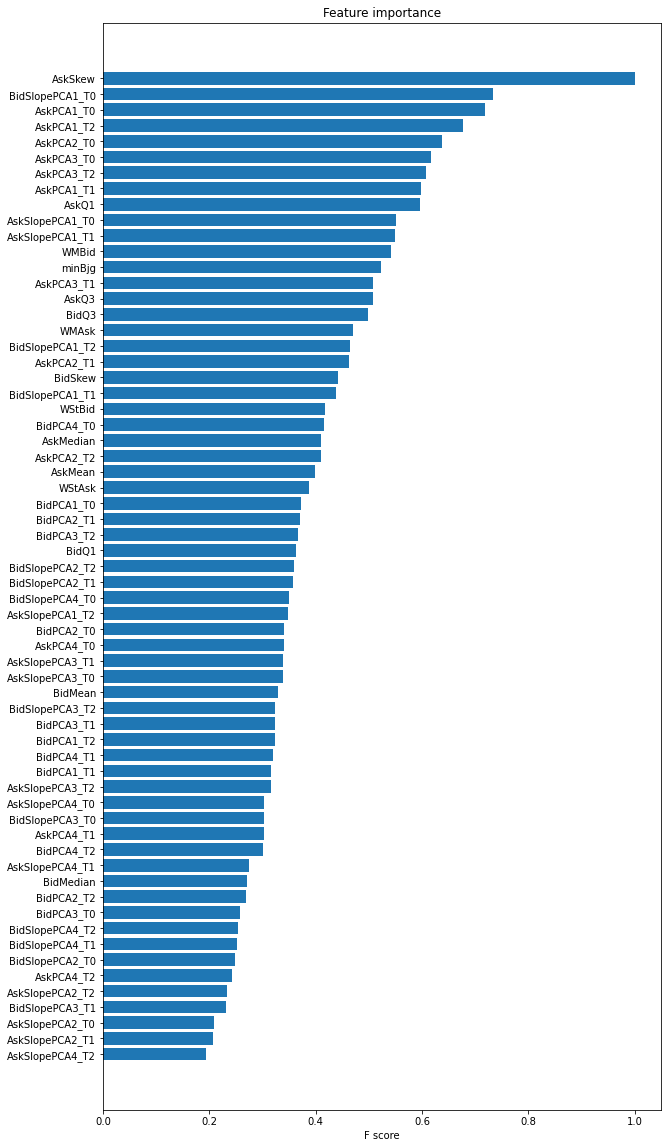

In [32]:
ftImp = rf3.best_estimator_.feature_importances_

# Nombres de las características
features = X3_train.columns

# Normalización importancias
ftImp = ftImp / np.max(ftImp, axis=0)

# Df para ordenar por importancia
featureImportance = pd.DataFrame({'ftImp': ftImp,'features': features })
featureImportance =featureImportance.sort_values(by=['ftImp'])
y_pos = np.arange(len(featureImportance['features']))

# Gráfico de barras
plt.figure(figsize=(10,20))
plt.barh(y_pos, featureImportance['ftImp'], align='center')
plt.yticks(y_pos, featureImportance['features'])
# plt.axvline(0.1, 0, 1, c='r')
plt.xlabel('F score')
plt.title('Feature importance')
plt.show()

## XGBoost

In [33]:
# Función
xgb3 = GridSearchCV(estimator = xgb, 
                    param_grid = xgb_param_grid,
                    scoring = 'accuracy',
                    cv = 5, 
                    verbose = 1,
                    n_jobs = 3, 
                    refit = True, 
                    return_train_score=True)

xgb3.fit(X3_train, y3_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 39.6min
[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed: 61.2min finished


[23:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=5, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=45,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_l

In [34]:
results_df6 = pd.concat([pd.DataFrame(xgb3.cv_results_["params"]),
                         pd.DataFrame(xgb3.cv_results_['mean_train_score'], columns = ["accuracy_train"]),
                         pd.DataFrame(xgb3.cv_results_['mean_test_score'], columns = ['accuracy_test'])], 
                         axis=1)

display(results_df6.sort_values(by = 'accuracy_test', ascending=False).head(10))

,learning_rate,n_estimators,reg_alpha,reg_lambda,accuracy_train,accuracy_test
53,0.1,300,1.000,1.000,0.880116,0.631931
52,0.1,300,1.000,0.100,0.891462,0.631163
51,0.1,300,1.000,0.001,0.891434,0.628590
49,0.1,300,0.100,0.100,0.889591,0.627784
47,0.1,300,0.001,1.000,0.881508,0.626286
48,0.1,300,0.100,0.001,0.889082,0.625672
45,0.1,300,0.001,0.001,0.889706,0.623906
43,0.1,200,1.000,0.100,0.861340,0.623790
42,0.1,200,1.000,0.001,0.859747,0.623752
44,0.1,200,1.000,1.000,0.848766,0.623099


Threshold value is: 0.49260744


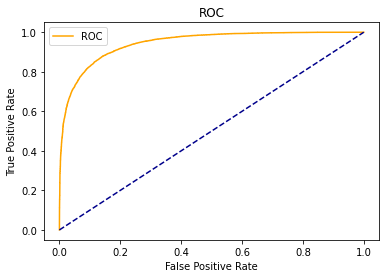

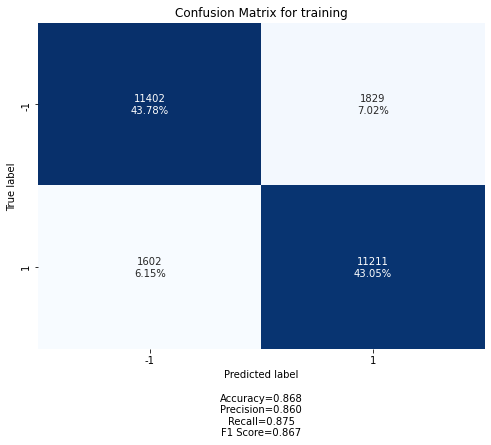

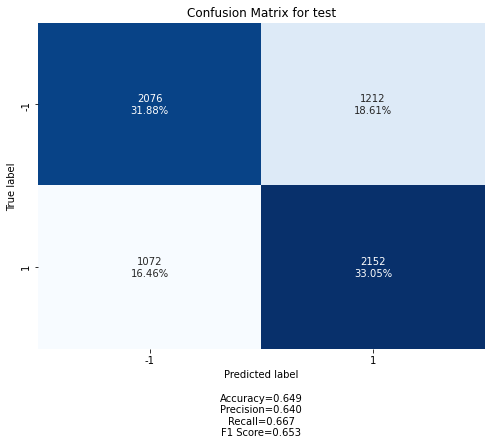

In [35]:
evaluate_model(xgb3, X3_train, y3_train, X3_test, y3_test)

# Modelización 4

## RandomForest

In [36]:
rf4 = GridSearchCV(
    estimator = rf,
    param_grid = rf_param_grid,
    scoring= 'accuracy',
    n_jobs = 3, 
    cv = 5, 
    refit = True, 
    return_train_score=True,
    verbose = True)

rf4.fit(X4_train, y4_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 17.8min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 24.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45), n_jobs=3,
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [0.01, 0.03, 0.05, 0.1],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [37]:
results_df7 = pd.concat([pd.DataFrame(rf4.cv_results_["params"]),
                         pd.DataFrame(rf4.cv_results_['mean_train_score'], columns = ["accuracy_train"]),
                         pd.DataFrame(rf4.cv_results_['mean_test_score'], columns = ['accuracy_test'])], 
                         axis=1)

display(results_df7.sort_values(by = 'accuracy_test', ascending=False).head(10))

,max_depth,min_samples_leaf,n_estimators,accuracy_train,accuracy_test
38,9,0.01,200,0.648892,0.586047
50,11,0.01,200,0.653749,0.585740
49,11,0.01,100,0.652252,0.584358
48,11,0.01,50,0.648566,0.582092
37,9,0.01,100,0.647164,0.582054
36,9,0.01,50,0.643027,0.579673
26,7,0.01,200,0.633860,0.579519
25,7,0.01,100,0.633284,0.579097
24,7,0.01,50,0.631902,0.578176
13,5,0.01,100,0.608518,0.571533


Threshold value is: 0.4944334922667696


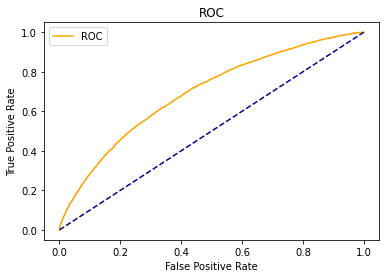

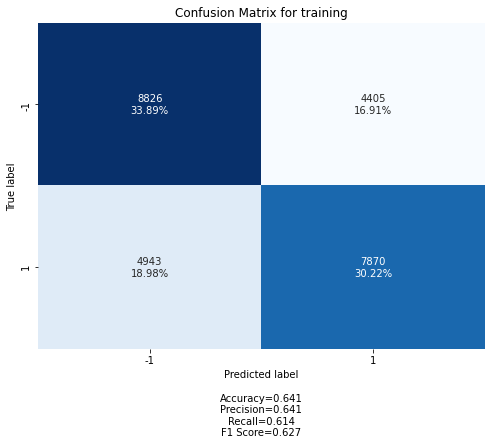

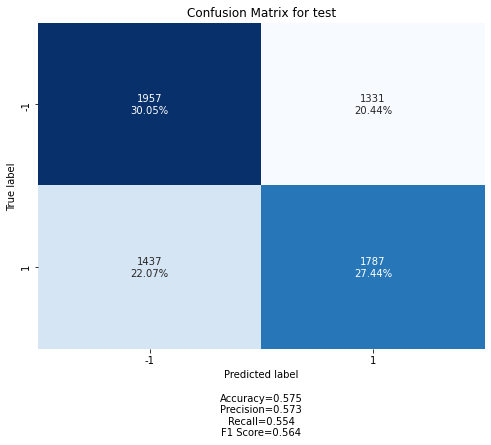

In [38]:
evaluate_model(rf4, X4_train, y4_train, X4_test, y4_test)

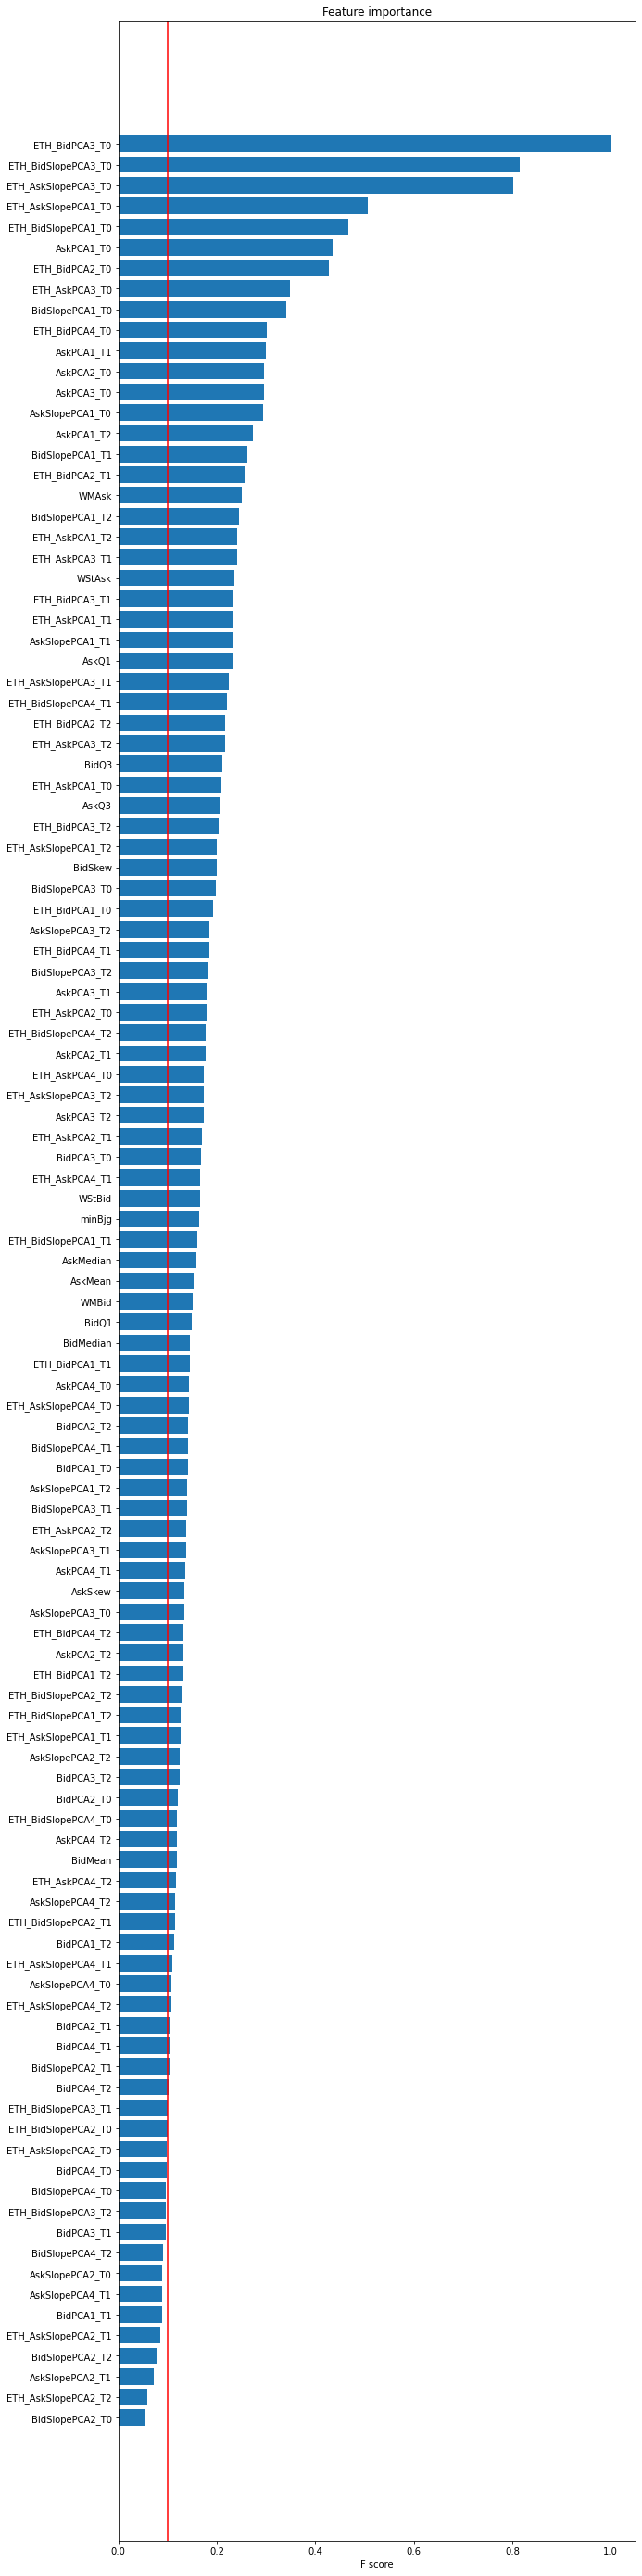

In [39]:
ftImp = rf4.best_estimator_.feature_importances_

# Nombres de las características
features = X4_train.columns

# Normalización importancias
ftImp = ftImp / np.max(ftImp, axis=0)

# Df para ordenar por importancia
featureImportance = pd.DataFrame({'ftImp': ftImp,'features': features })
featureImportance =featureImportance.sort_values(by=['ftImp'])
y_pos = np.arange(len(featureImportance['features']))

# Gráfico de barras
plt.figure(figsize=(10,50))
plt.barh(y_pos, featureImportance['ftImp'], align='center')
plt.yticks(y_pos, featureImportance['features'])
plt.axvline(0.1, 0, 1, c='r')
plt.xlabel('F score')
plt.title('Feature importance')
plt.show()

## XGBoost

In [40]:
xgb4 = GridSearchCV(estimator = xgb, 
                    param_grid = xgb_param_grid,
                    scoring = 'accuracy',
                    cv = 5, 
                    verbose = 1,
                    n_jobs = 3, 
                    refit = True, 
                    return_train_score=True)

xgb4.fit(X4_train, y4_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 10.2min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 71.3min
[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed: 109.3min finished


[01:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=5, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=45,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_l

In [41]:
results_df8 = pd.concat([pd.DataFrame(xgb4.cv_results_["params"]),
                         pd.DataFrame(xgb4.cv_results_['mean_train_score'], columns = ["accuracy_train"]),
                         pd.DataFrame(xgb4.cv_results_['mean_test_score'], columns = ['accuracy_test'])], 
                         axis=1)

display(results_df8.sort_values(by = 'accuracy_test', ascending=False).head(10))

,learning_rate,n_estimators,reg_alpha,reg_lambda,accuracy_train,accuracy_test
52,0.1,300,1.000,0.100,0.921114,0.650783
51,0.1,300,1.000,0.001,0.922516,0.647289
47,0.1,300,0.001,1.000,0.916871,0.646982
48,0.1,300,0.100,0.001,0.922228,0.646253
53,0.1,300,1.000,1.000,0.914366,0.646061
49,0.1,300,0.100,0.100,0.924532,0.645677
46,0.1,300,0.001,0.100,0.918782,0.645100
45,0.1,300,0.001,0.001,0.919828,0.643910
43,0.1,200,1.000,0.100,0.889101,0.642682
50,0.1,300,0.100,1.000,0.915873,0.641760


Threshold value is: 0.49017552


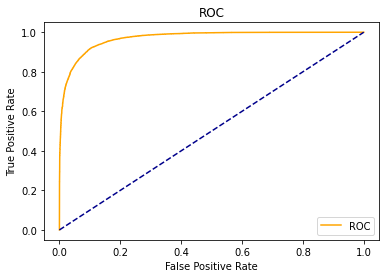

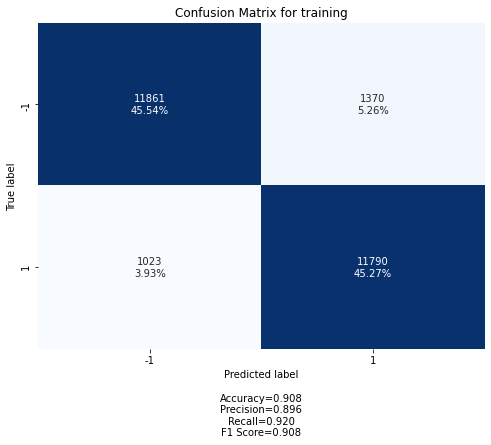

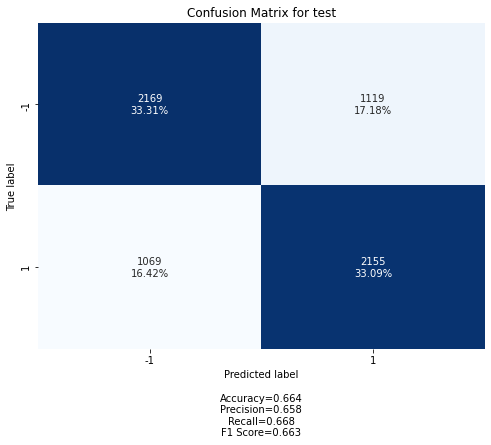

In [42]:
evaluate_model(xgb4, X4_train, y4_train, X4_test, y4_test)

# Guardamos los modelos

In [65]:
import pickle

In [74]:
pkl_filename = "xgb4.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb4, file)

In [ ]:
# with open(pkl_filename, 'rb') as file:
    # pickle_model = pickle.load(file)